## Imports

In [145]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotnine as p9
import statsmodels.formula.api as smf

import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Load Yahoo Data

We will be getting Dividend Adjusted data -> which could be the difference between Yahoo and TradingView data

In [146]:
# tickers = ['SPY', 'TLT']
# ydata = yf.Tickers(tickers).download(period="max", auto_adjust=True)   # get dividend adjusted prices

Convert Yahoo Data to long-format

In [147]:
# data = (   # put data in long form
#     ydata
#     .dropna()
#     .stack(1, future_stack=True)
#     .reset_index()
#     [['Date', 'Ticker', 'Close']]
#     .sort_values(by=['Date', 'Ticker'])
# )

# data.head(5)

In [148]:
# # download historical data from Yahoo Finance to csv, file name data_<tickers>_2002-07-30_D.csv
# data.to_csv('data_SPY_TLT_2002-07-30_D.csv', index=False)

## Create return data for the various periods of Month defined by (N, M)

In [149]:
# read data from csv
data = pd.read_csv('data_SPY_TLT_2002-07-30_D.csv')
data['Date'] = pd.to_datetime(data['Date'])
print(data.info())
print(data.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11700 entries, 0 to 11699
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11700 non-null  datetime64[ns]
 1   Ticker  11700 non-null  object        
 2   Close   11700 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 274.3+ KB
None
        Date Ticker      Close
0 2002-07-30    SPY  59.177753
1 2002-07-30    TLT  37.055656
2 2002-07-31    SPY  59.320934
3 2002-07-31    TLT  37.514767
4 2002-08-01    SPY  57.772179


In [150]:
N = 15
M = 5

# Start fresh with daily data - don't aggregate to monthly yet
data = pd.read_csv('data_SPY_TLT_2002-07-30_D.csv')
data['Date'] = pd.to_datetime(data['Date'])

def flatten_indexes(df_: pd.DataFrame) -> pd.DataFrame:
    df_.columns = [x[1] + "_" + x[0] if x[1]!='' else x[0] for x in df_.columns]
    return df_

return_data = (
    data
    .assign(
        ym=lambda x: x['Date'] + pd.offsets.MonthEnd(0)  # Label by year-month
    )
    .groupby(['Ticker', 'ym'])
    .apply(lambda x: x.assign(
        td=lambda y: range(1, len(y)+1)  # Trading days 1 to N per month
    ), include_groups=False).reset_index([0, 1])
    
    .groupby(['Ticker'])
    .apply(lambda x: x.assign(
        ret=lambda y: y['Close'].pct_change()  # Daily returns
    ), include_groups=False).reset_index()
    
    .query('Date >= @dt.datetime(2002, 8, 1)')  # Remove July 2002
    [['Date', 'ym', 'Ticker', 'Close', 'ret', 'td']]
    
    .assign(
        som_flag=lambda x: np.select([x['td'] <= N], [1], [0]),   # First 15 days
        eom_flag=lambda x: np.select([x['td'] > N], [1], [0]),    # After day 15  
        nsm_flag=lambda x: np.select([x['td'] <= M], [1], [0]),   # First 5 days
        
        ret_som=lambda x: x['som_flag'] * x['ret'],  # Flagged returns
        ret_eom=lambda x: x['eom_flag'] * x['ret'],
        ret_nsm=lambda x: x['nsm_flag'] * x['ret'],
    )
    
    [['Date', 'ym', 'Ticker', 'ret_som', 'ret_eom', 'ret_nsm']]
    
    .pivot(index=['Date', 'ym'], columns=['Ticker'], values=['ret_som', 'ret_eom', 'ret_nsm'])
    .pipe(flatten_indexes)
    
    .assign(
        SPY_ret=lambda x: x['SPY_ret_som'] + x['SPY_ret_eom'],      # Total SPY return
        SPY_TLT_som=lambda x: x['SPY_ret_som'] - x['TLT_ret_som'],  # Relative returns
        SPY_TLT_eom=lambda x: x['SPY_ret_eom'] - x['TLT_ret_eom'],
        SPY_TLT_nsm=lambda x: x['SPY_ret_nsm'] - x['TLT_ret_nsm'],
    )
    [['SPY_ret', 'SPY_ret_eom', 'SPY_ret_nsm', 'TLT_ret_eom', 'TLT_ret_nsm', 
      'SPY_TLT_som', 'SPY_TLT_eom', 'SPY_TLT_nsm']]
      
    .groupby(['ym'])
    .agg(lambda x: (1+x).prod() - 1)  # Compound monthly returns
)

return_data.tail(5)

,SPY_ret,SPY_ret_eom,SPY_ret_nsm,TLT_ret_eom,TLT_ret_nsm,SPY_TLT_som,SPY_TLT_eom,SPY_TLT_nsm
ym,,,,,,,,
2025-06-30,0.051386,0.029493,0.016542,0.017057,-0.007096,0.010480,0.012145,0.023078
2025-07-31,0.023032,0.005120,0.004030,0.004623,-0.021519,0.033781,0.000007,0.025907
2025-08-31,0.020520,0.014948,0.000269,0.002199,0.012484,0.006702,0.012749,-0.012571
2025-09-30,0.035620,-0.000990,0.005860,0.007554,0.040198,0.007519,-0.008637,-0.033473
2025-10-31,0.028611,0.020781,0.004413,-0.002391,0.001347,-0.025525,0.023167,0.002909


## Relation between SOM and EOM relative returns

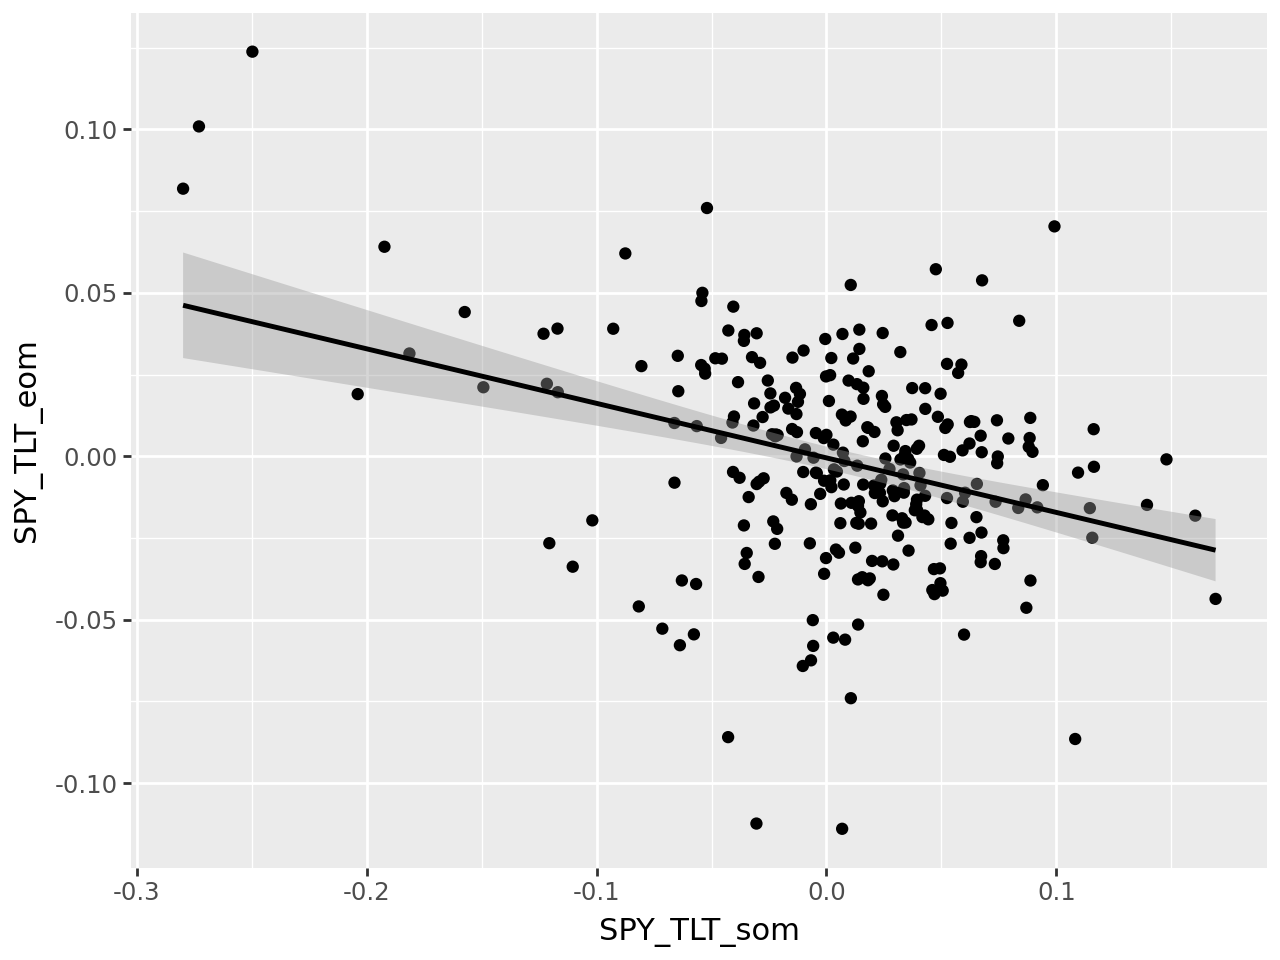

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_eom   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     35.75
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           6.89e-09
Time:                        20:34:25   Log-Likelihood:                 591.77
No. Observations:                 279   AIC:                            -1180.
Df Residuals:                     277   BIC:                            -1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0005      0.002     -0.286      

In [151]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som', y='SPY_TLT_eom')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()                                                           # have to explicitly call show otherwise only get print statement below

mod = smf.ols('SPY_TLT_eom ~ SPY_TLT_som', return_data)
res = mod.fit()
print(res.summary())

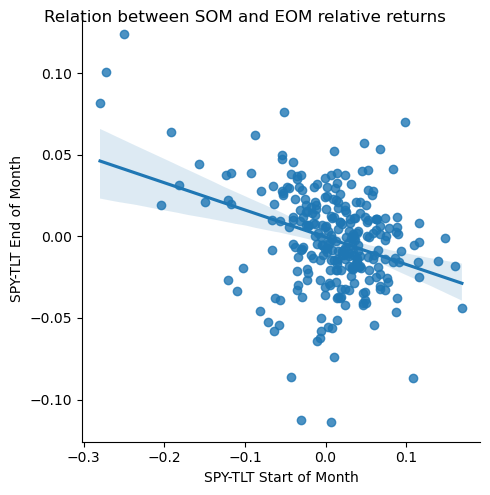

In [152]:
# plot using seaborn with customization
g = sns.lmplot(x='SPY_TLT_som', y='SPY_TLT_eom', data=return_data)
g.set_axis_labels('SPY-TLT Start of Month', 'SPY-TLT End of Month')
g.fig.suptitle('Relation between SOM and EOM relative returns')
plt.show()

## Relationship between EOM and Next SOM

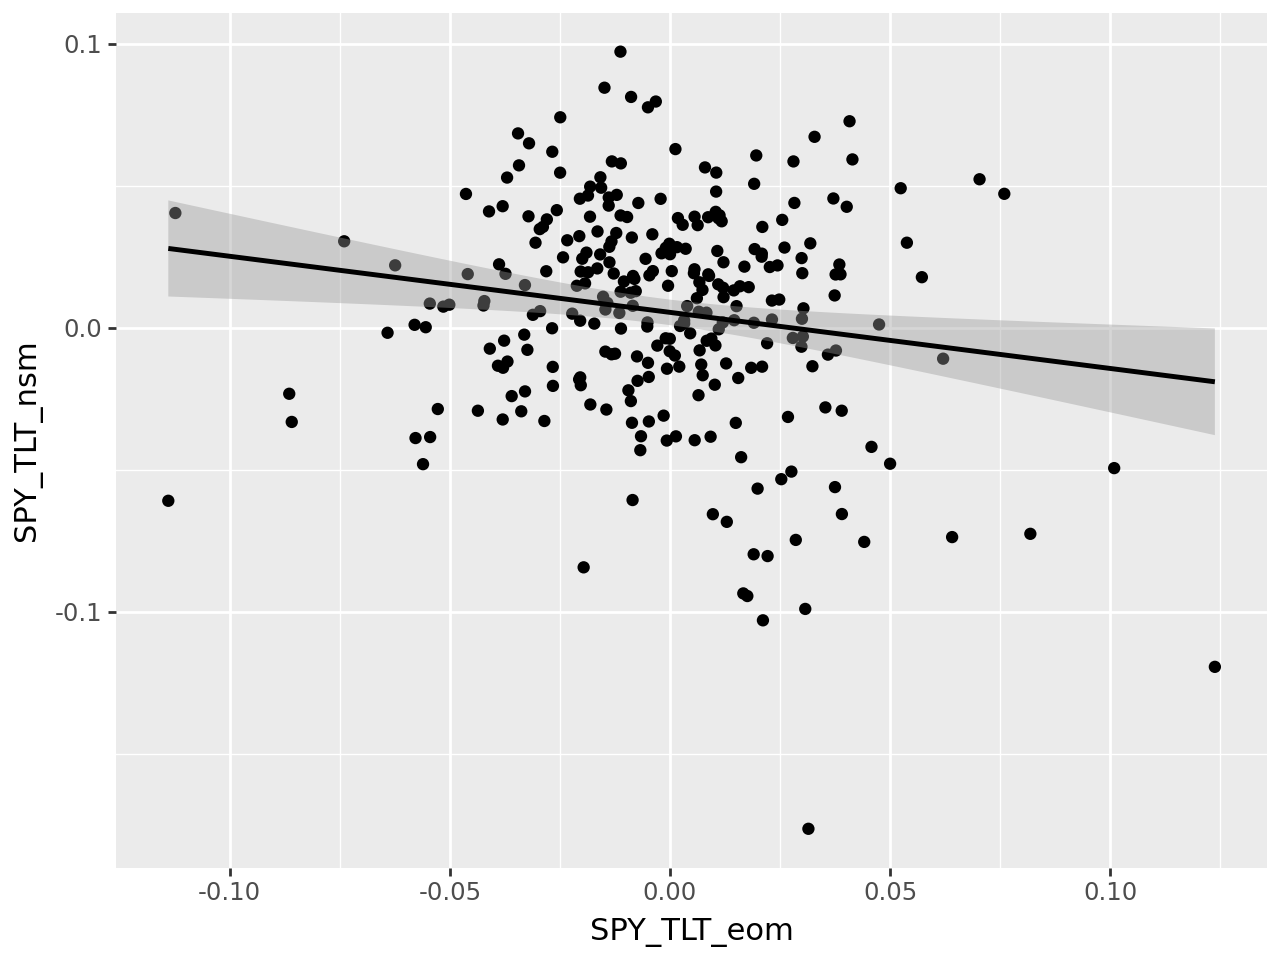

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.152
Date:                Wed, 29 Oct 2025   Prob (F-statistic):            0.00793
Time:                        20:34:26   Log-Likelihood:                 517.14
No. Observations:                 279   AIC:                            -1030.
Df Residuals:                     277   BIC:                            -1023.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0054      0.002      2.379      

In [153]:
# plot using pilotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_eom', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_eom', return_data)
res = mod.fit()
print(res.summary())

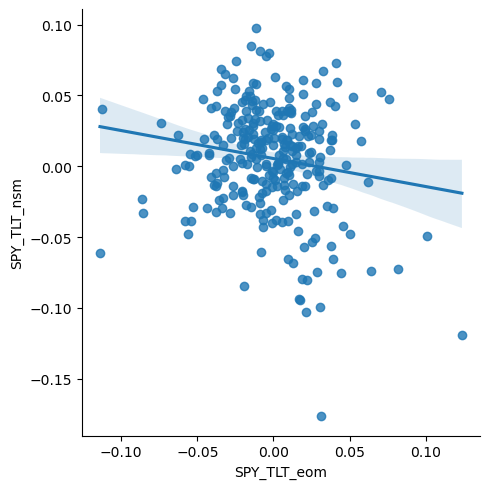

In [154]:
# plot using seaborn
sns.lmplot(x='SPY_TLT_eom', y='SPY_TLT_nsm', data=return_data)
plt.show()

## Relationship between SOM and Next SOM

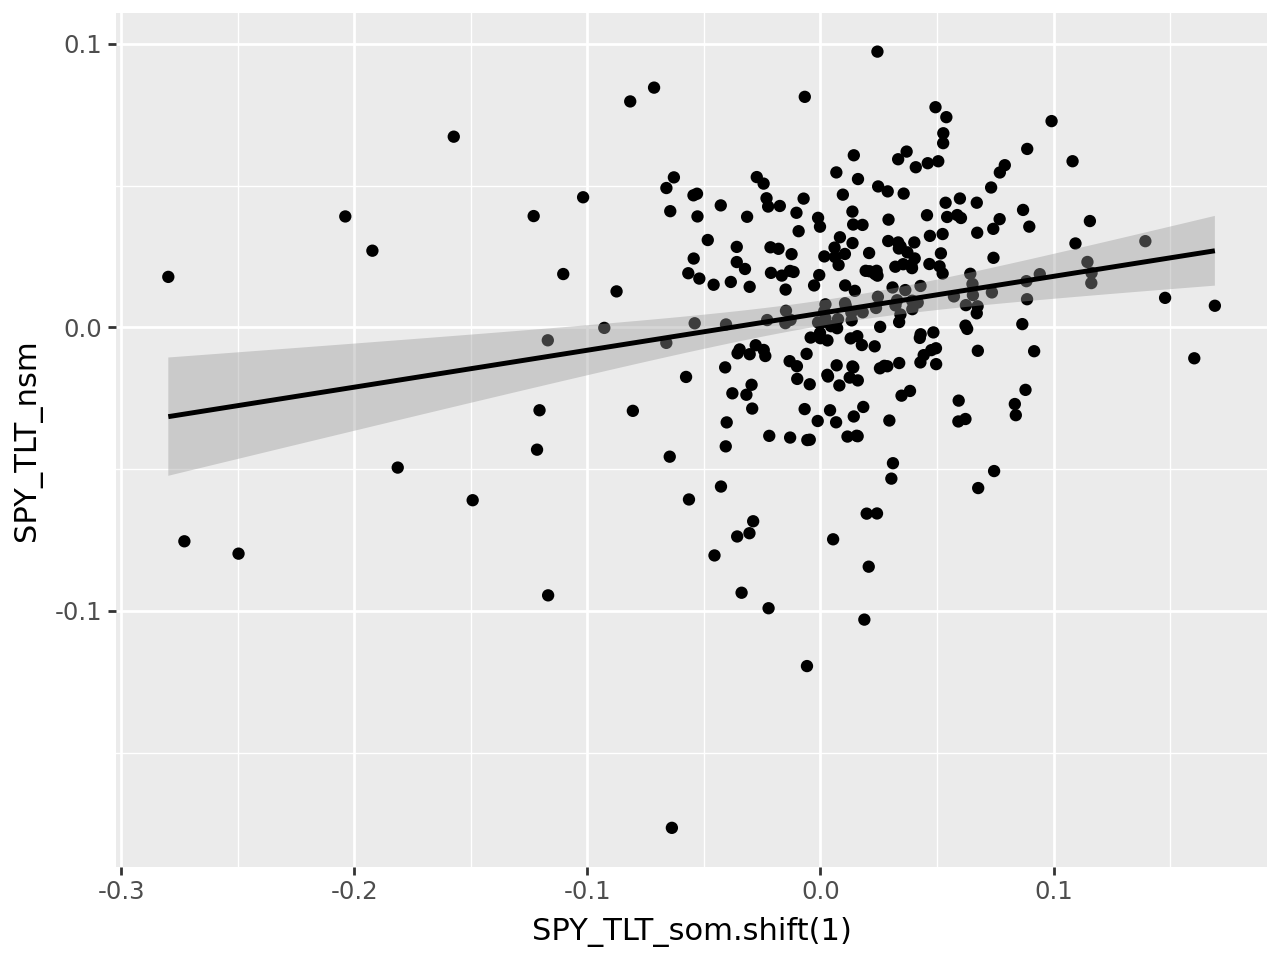

                            OLS Regression Results                            
Dep. Variable:            SPY_TLT_nsm   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     13.07
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           0.000357
Time:                        20:34:26   Log-Likelihood:                 518.66
No. Observations:                 278   AIC:                            -1033.
Df Residuals:                     276   BIC:                            -1026.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0050 

In [155]:
# plot using plotnine
(
    return_data
    .pipe(p9.ggplot)
    + p9.aes(x='SPY_TLT_som.shift(1)', y='SPY_TLT_nsm')
    + p9.geom_point()
    + p9.geom_smooth(method="lm")
).show()

mod = smf.ols('SPY_TLT_nsm ~ SPY_TLT_som.shift(1)', return_data)
res = mod.fit()
print(res.summary())

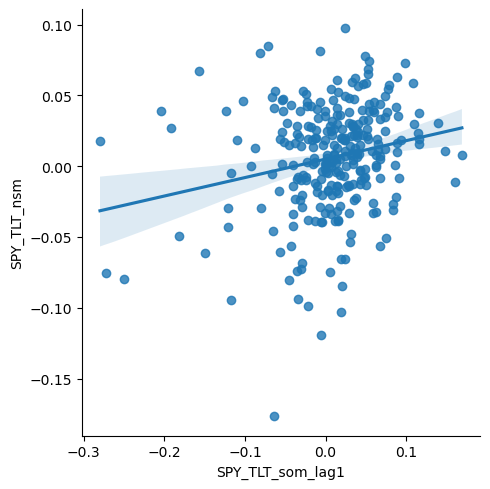

In [ ]:
# Create shifted column, then plot using seaborn
return_data_shifted = return_data.assign(SPY_TLT_som_lag1=lambda x: x['SPY_TLT_som'].shift(1))

sns.lmplot(x='SPY_TLT_som_lag1', y='SPY_TLT_nsm', data=return_data_shifted)
plt.show()